**Excercise 1**
Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. 
Plot the train and validation loss curves of all autoencoders in the same figure.
4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. 
Show the results in a table, including #params of each model.
5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.
6. Generate 5 new images by injecting random values as input to the decoder. Show them.


In [1]:
import torch
import copy
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from keras.layers import Input, Dense,  Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard


Using TensorFlow backend.


Parameters definition

In [0]:
#constants
Neck_Sizes = [4,30,100]
TraiSetSize = 60000
SplitTraning = 95
SplitTraningSize = int(TraiSetSize*SplitTraning/100)
SpitValidationSize = TraiSetSize-SplitTraningSize

# Let's define some hyper-parameters
hparams = {
    'batch_size':256,
    'num_epochs':50,
    'test_batch_size':64,
    'val_batch_size': 64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

# whenever we send something to the selected device (X.to(device)) we already use
# either CPU or CUDA (GPU). Importantly...
# The .to() operation is in-place for nn.Module's, so network.to(device) suffices
# The .to() operation is NOT in.place for tensors, so we must assign the result
# to some tensor, like: X = X.to(device)

**EXERCISE 1.** Load MNIST train and test sets. Split the original training data 
into 95% training and 5% validation data.

IMport MNIST dataset

In [3]:
#transform = transforms.Compose(
#    [transforms.ToTensor(),
 #    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))

mnist_valset =copy.deepcopy(mnist_trainset)

mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

mnist_valset.data = mnist_trainset.data[SplitTraningSize:TraiSetSize]
mnist_valset.targets = mnist_trainset.targets[SplitTraningSize:TraiSetSize]

mnist_trainset.data = mnist_trainset.data[:SplitTraningSize]
mnist_trainset.targets = mnist_trainset.targets[:SplitTraningSize]

train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    mnist_valset,
    batch_size=hparams['val_batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

mnist_trainset.data = mnist_trainset.data /255.
mnist_valset.data = mnist_valset.data/255.
mnist_testset.data = mnist_testset.data/255.

#RESHAPE autoencoder xulo
#mnist_trainset.data = np.reshape(mnist_trainset.data, (len(mnist_trainset.data), 28, 28, 1))  # adapt this if using `channels_first` image data format
#mnist_evalset.data = np.reshape(mnist_evalset.data, (len(mnist_evalset.data), 28, 28, 1))  # adapt this if using `channels_first` image data format

#RESHAPE per normalitzar les dades de autoencoder cutre
mnist_trainset.data = mnist_trainset.data.reshape((len(mnist_trainset.data), np.prod(mnist_trainset.data.shape[1:])))
mnist_valset.data = mnist_valset.data.reshape((len(mnist_valset.data), np.prod(mnist_valset.data.shape[1:])))
mnist_testset.data = mnist_testset.data.reshape((len(mnist_testset.data), np.prod(mnist_testset.data.shape[1:])))


print(mnist_trainset.data.shape)
print(mnist_trainset.targets.shape)

print(mnist_valset.data.shape)
print(mnist_valset.targets.shape)


torch.Size([57000, 784])
torch.Size([57000])
torch.Size([3000, 784])
torch.Size([3000])


**EXERCISE 2:** Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
FIRST IMPLEMENTATION: simple autoencoder, 1 hidden layer

Model creation function






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 57000 samples, validate on 3000 samples
Epoch 1/50





57000/57000 [==============================] - 6s 108us/step - loss: 0.3872 - val_loss: 0.2764
Epoch 2/50
57000/57000 [==============================] - 1s 17us/step - loss: 0.2730 - val_loss: 0.2697
Epoch 3/50
57000/57000 [==============================] - 1s 17us/step - loss: 0.2660 - val_loss: 0.2608
Epoch 4/50
57000/57000 [==============================] - 1s 17us/step - loss: 0.2555 - val_loss: 0.2503
Epoch 5/50
57000/57000 [==============================] - 1s 17us/step - loss: 0.2464 - val_loss: 0.2429
Epoch 6/50
57000/57000 [==============================] - 1s 17us/step - loss: 0.2411 - val_loss: 0.2397
Epoch 7/50
57000/57000 [==============================] - 1s 17us/step - loss: 0.2388 - val_loss: 0.2382
Epoch 8/50
57000/57000 [==============================] - 1s 17us/step - loss: 0.2374 - val_loss: 0.2374
Epo

Text(0, 0.5, 'NLLLoss')

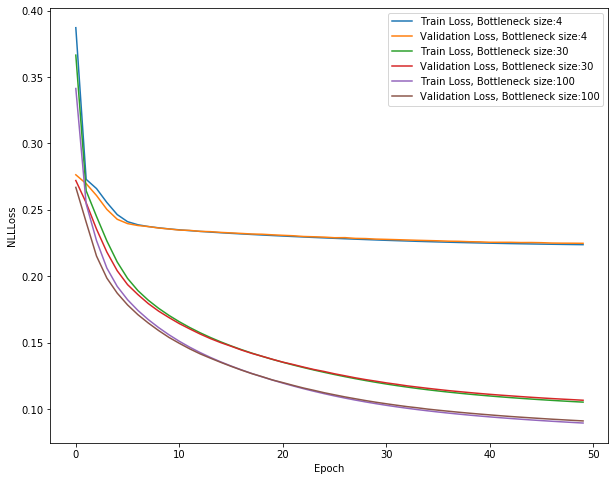

In [4]:
# this is the size of our encoded representations
plt.figure(figsize=(10, 8))

for i in range (len(Neck_Sizes)):
  encoding_dim = Neck_Sizes[i]
  input_img = Input(shape=(784,))
  # "encoded" is the encoded representation of the input
  encoded = Dense(encoding_dim, activation='relu')(input_img)
  # "decoded" is the lossy reconstruction of the input
  decoded = Dense(784, activation='sigmoid')(encoded)

  # this model maps an input to its reconstruction
  autoencoder = Model(input_img, decoded)

  #CREATE an individual ENCODER: this model maps an input to its encoded representation
  encoder = Model(input_img, encoded)

  # CREATE an individual DECODER: create a placeholder for an encoded (32-dimensional) input
  encoded_input = Input(shape=(encoding_dim,))
  # retrieve the last layer of the autoencoder model
  decoder_layer = autoencoder.layers[-1]
  # create the decoder model
  decoder = Model(encoded_input, decoder_layer(encoded_input))

  # Define the optimizer and loss function for the autoencoder
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

  # TRAIN
  history = autoencoder.fit(mnist_trainset.data, mnist_trainset.data,
                hparams['batch_size'],
                hparams['num_epochs'],
                shuffle=True,
                validation_data=(mnist_valset.data, mnist_valset.data))
  encoded_imgs = encoder.predict(mnist_trainset.data)
  decoded_imgs = decoder.predict(encoded_imgs)

  train_loss=history.history['loss']
  val_loss=history.history['val_loss']


  #plt.subplot(2,1,1)
  plt.plot(train_loss, label='Train Loss, Bottleneck size:' + str(Neck_Sizes[i]))
  plt.plot(val_loss, label='Validation Loss, Bottleneck size:' + str(Neck_Sizes[i]))

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

**EXERCISE 3:** Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 57000 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


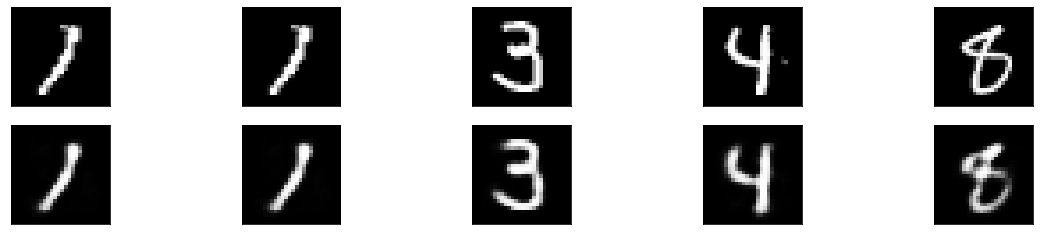

In [5]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
ps=np.random.random_integers(mnist_trainset.data.shape[0])

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_trainset.data[ps].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[ps].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ps = ps + i
plt.show()




**EXERCISE 4:** Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.

In [6]:
#Change the Loss Function to MSE
autoencoder.compile(optimizer='RMSprop', loss='mean_squared_error')

# TRAIN validations with test
history = autoencoder.fit(mnist_valset.data, mnist_valset.data,
                hparams['batch_size'],
                hparams['num_epochs'],
                shuffle=True,
                validation_data=(mnist_testset.data, mnist_testset.data))

encoded_imgs = encoder.predict(mnist_valset.data)
decoded_imgs = decoder.predict(encoded_imgs)

Train on 3000 samples, validate on 10000 samples
Epoch 1/50
3000/3000 [==============================] - 0s 119us/step - loss: 0.0102 - val_loss: 0.0083
Epoch 2/50
3000/3000 [==============================] - 0s 43us/step - loss: 0.0090 - val_loss: 0.0082
Epoch 3/50
3000/3000 [==============================] - 0s 46us/step - loss: 0.0088 - val_loss: 0.0085
Epoch 4/50
3000/3000 [==============================] - 0s 45us/step - loss: 0.0083 - val_loss: 0.0089
Epoch 5/50
3000/3000 [==============================] - 0s 45us/step - loss: 0.0084 - val_loss: 0.0087
Epoch 6/50
3000/3000 [==============================] - 0s 45us/step - loss: 0.0083 - val_loss: 0.0085
Epoch 7/50
3000/3000 [==============================] - 0s 42us/step - loss: 0.0083 - val_loss: 0.0083
Epoch 8/50
3000/3000 [==============================] - 0s 47us/step - loss: 0.0081 - val_loss: 0.0079
Epoch 9/50
3000/3000 [==============================] - 0s 42us/step - loss: 0.0080 - val_loss: 0.0081
Epoch 10/50
3000/3000 [

Print and compare the MSE from the validation and test data

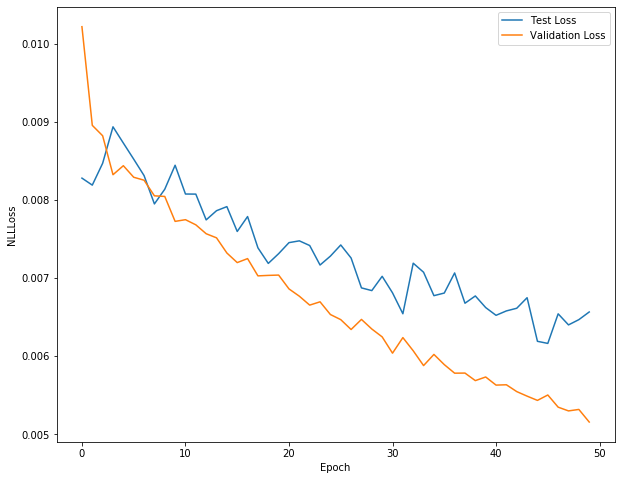

In [7]:
val_loss=history.history['loss']
test_loss=history.history['val_loss']

plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(test_loss, label='Test Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend()

Show the results in a table, including #params of each model.

In [8]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               79184     
Total params: 157,684
Trainable params: 157,684
Non-trainable params: 0
_________________________________________________________________
